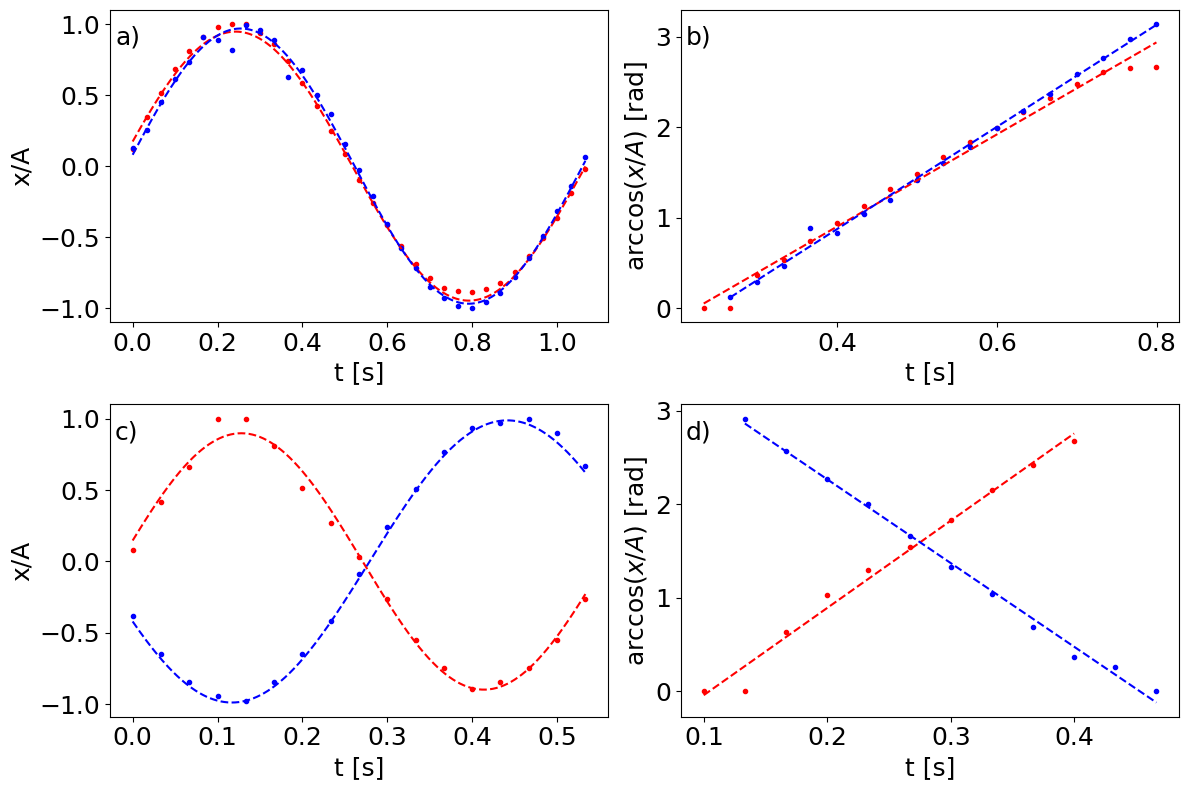


=== Resultados de regresión para: Archivo 1 ===
θ₁(t): ω₁ = 5.1017 ± 0.1500 rad/s
         ϕ₁ = -1.1397 rad
θ₂(t): ω₂ = 5.6572 ± 0.0884 rad/s
         ϕ₂ = -1.3892 rad

=== Resultados de regresión para: Archivo 2 ===
θ₁(t): ω₁ = 9.3217 ± 0.3950 rad/s
         ϕ₁ = -0.9713 rad
θ₂(t): ω₂ = -8.9449 ± 0.2068 rad/s
         ϕ₂ = 4.0547 rad


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# === Funciones auxiliares ===
def modelo_coseno(t, A, w, phi):
    return A * np.cos(w * t + phi)

def detectar_cruces_cero(x, t):
    cruces = []
    for i in range(1, len(x)):
        if x[i-1] < 0 and x[i] >= 0:
            t0 = t[i-1] + (0 - x[i-1]) * (t[i] - t[i-1]) / (x[i] - x[i-1])
            cruces.append((i, t0))
    return cruces

def datos_arccos(t, x_n):
    idx_min = np.argmin(x_n)
    idx_max = np.argmax(x_n)
    if idx_min > idx_max:
        idx_min, idx_max = idx_max, idx_min
    t_seg = t[idx_min:idx_max+1]
    y_seg = np.arccos(x_n[idx_min:idx_max+1])
    return t_seg, y_seg

def ajuste_lineal(t, y):
    slope, intercept, r_value, _, stderr = linregress(t, y)
    return slope, intercept, r_value**2, stderr

def procesar_datos(ruta_csv, numero_periodo):
    df = pd.read_csv(ruta_csv)
    df['x_rojo_c'] = df['x_rojo'] - df['x_rojo'].mean()
    df['x_azul_c'] = df['x_azul'] - df['x_azul'].mean()
    t = df['tiempo_s'].values
    x1 = df['x_rojo_c'].values
    x2 = df['x_azul_c'].values

    cruces_cero = detectar_cruces_cero(x1, t)
    idx_ini = cruces_cero[numero_periodo][0]
    idx_fin = cruces_cero[numero_periodo+1][0]
    t_p = t[idx_ini:idx_fin] - t[idx_ini]
    x1_p = x1[idx_ini:idx_fin]
    x2_p = x2[idx_ini:idx_fin]

    T_est = t_p[-1] - t_p[0]
    w_est = 2 * np.pi / T_est
    p0 = [np.max(np.abs(x1_p)), w_est, 0]
    popt1, _ = curve_fit(modelo_coseno, t_p, x1_p, p0=p0)
    popt2, _ = curve_fit(modelo_coseno, t_p, x2_p, p0=p0)

    A1 = np.max(np.abs(x1_p))
    A2 = np.max(np.abs(x2_p))
    x1_n = x1_p / A1
    x2_n = x2_p / A2

    t1_arccos, y1_arccos = datos_arccos(t_p, x1_n)
    t2_arccos, y2_arccos = datos_arccos(t_p, x2_n)
    slope1, intercept1, _, _ = ajuste_lineal(t1_arccos, y1_arccos)
    slope2, intercept2, _, _ = ajuste_lineal(t2_arccos, y2_arccos)

    return {
        't_p': t_p, 'x1_n': x1_n, 'x2_n': x2_n,
        'popt1': popt1, 'popt2': popt2, 'A1': A1, 'A2': A2,
        't1_arccos': t1_arccos, 'y1_arccos': y1_arccos,
        't2_arccos': t2_arccos, 'y2_arccos': y2_arccos,
        'slope1': slope1, 'intercept1': intercept1,
        'slope2': slope2, 'intercept2': intercept2
    }

def graficar_resultados(data1, data2):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    sizeLetras = 18

    for i, data in enumerate([data1, data2]):
        row = i

        # a, c: Señales normalizadas + ajuste
        t_fit = np.linspace(data['t_p'].min(), data['t_p'].max(), 500)
        axs[row, 0].plot(data['t_p'], data['x1_n'], 'r.')
        axs[row, 0].plot(data['t_p'], data['x2_n'], 'b.')
        axs[row, 0].plot(t_fit, modelo_coseno(t_fit, *data['popt1']) / data['A1'], 'r--')
        axs[row, 0].plot(t_fit, modelo_coseno(t_fit, *data['popt2']) / data['A2'], 'b--')
        axs[row, 0].set_xlabel('t [s]', fontsize=sizeLetras)
        axs[row, 0].set_ylabel('x/A', fontsize=sizeLetras)
        axs[row, 0].tick_params(labelsize=sizeLetras)
        axs[row, 0].text(0.01, 0.95, f"{chr(97 + row*2)})", transform=axs[row, 0].transAxes,
                         fontsize=sizeLetras, va='top')

        # b, d: arccos + regresión
        axs[row, 1].plot(data['t1_arccos'], data['y1_arccos'], 'r.')
        axs[row, 1].plot(data['t2_arccos'], data['y2_arccos'], 'b.')
        axs[row, 1].plot(data['t1_arccos'], data['slope1'] * data['t1_arccos'] + data['intercept1'], 'r--')
        axs[row, 1].plot(data['t2_arccos'], data['slope2'] * data['t2_arccos'] + data['intercept2'], 'b--')
        axs[row, 1].set_xlabel('t [s]', fontsize=sizeLetras)
        axs[row, 1].set_ylabel(r'$\arccos(x/A)$ [rad]', fontsize=sizeLetras)
        axs[row, 1].tick_params(labelsize=sizeLetras)
        axs[row, 1].text(0.01, 0.95, f"{chr(98 + row*2)})", transform=axs[row, 1].transAxes,
                         fontsize=sizeLetras, va='top')

    plt.tight_layout()
    plt.show()

# === Rutas y parámetros
ruta1 = '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv'
ruta2 = '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosModoRapido/trayectorias.csv'
periodo1 = 6
periodo2 = 20

datos1 = procesar_datos(ruta1, periodo1)
datos2 = procesar_datos(ruta2, periodo2)
graficar_resultados(datos1, datos2)

# === Mostrar resultados de regresión
def imprimir_regresiones(nombre, datos):
    print(f"\n=== Resultados de regresión para: {nombre} ===")
    print(f"θ₁(t): ω₁ = {datos['slope1']:.4f} ± {linregress(datos['t1_arccos'], datos['y1_arccos']).stderr:.4f} rad/s")
    print(f"         ϕ₁ = {datos['intercept1']:.4f} rad")
    print(f"θ₂(t): ω₂ = {datos['slope2']:.4f} ± {linregress(datos['t2_arccos'], datos['y2_arccos']).stderr:.4f} rad/s")
    print(f"         ϕ₂ = {datos['intercept2']:.4f} rad")

imprimir_regresiones("Archivo 1", datos1)
imprimir_regresiones("Archivo 2", datos2)


⏳ Procesando: Archivo 1

--- Archivo 1 - ROJO ---
A1 = 154.013 ± 1.240
ω1 = 5.7903 ± 0.0339 rad/s
φ1 = -1.379 ± 0.021 rad
A2 = -8.571 ± 1.180
ω2 = 9.4684 ± 0.3682 rad/s
φ2 = 1.870 ± 0.288 rad
R²  = 0.99977

--- Archivo 1 - AZUL ---
A1 = 166.238 ± 0.829
ω1 = 5.8221 ± 0.0216 rad/s
φ1 = -1.394 ± 0.015 rad
A2 = 6.703 ± 0.795
ω2 = 12.0194 ± 0.6003 rad/s
φ2 = 0.488 ± 0.385 rad
R²  = 0.99952

⚠️  Error en Archivo 1: x and y must have same first dimension, but have shapes (32,) and (31,)

⏳ Procesando: Archivo 2

--- Archivo 2 - ROJO ---
A1 = 30.629 ± 0.529
ω1 = 10.1255 ± 0.1304 rad/s
φ1 = -1.322 ± 0.054 rad
A2 = -2.492 ± 0.530
ω2 = 20.1128 ± 1.7211 rad/s
φ2 = 0.742 ± 0.639 rad
R²  = 0.99692

--- Archivo 2 - AZUL ---
A1 = 34.327 ± 1.991
ω1 = 9.7093 ± 0.3312 rad/s
φ1 = 2.193 ± 0.125 rad
A2 = -1.656 ± 2.017
ω2 = 38.6853 ± 6.8502 rad/s
φ2 = -4.064 ± 2.321 rad
R²  = 0.95830


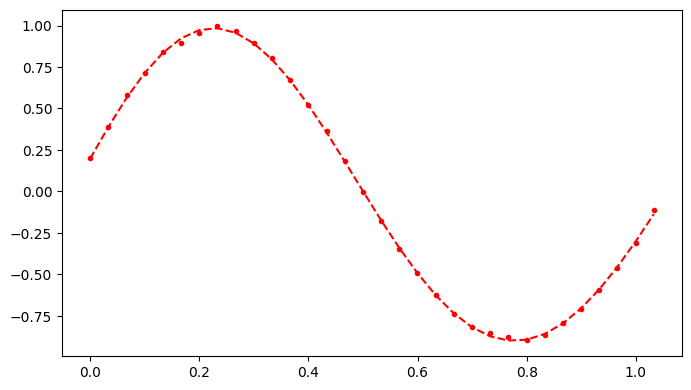

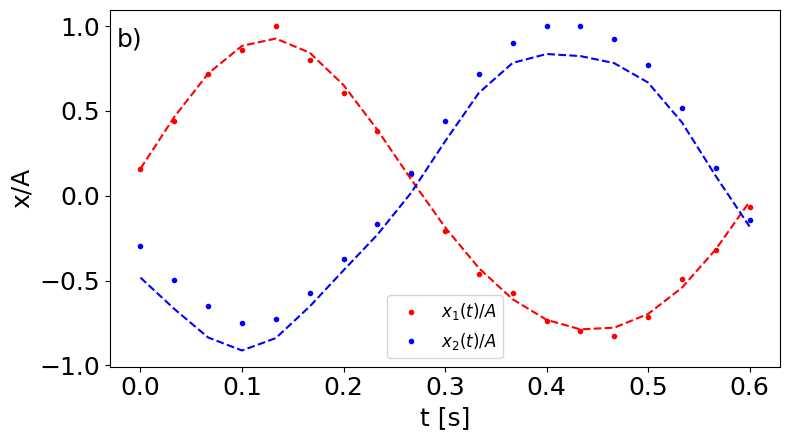


⏳ Procesando: Archivo 3

--- Archivo 3 - ROJO ---
A1 = 38.267 ± 0.475
ω1 = 14.6312 ± 0.1264 rad/s
φ1 = -1.152 ± 0.020 rad
A2 = -0.972 ± 0.489
ω2 = 26.6240 ± 4.2999 rad/s
φ2 = 0.428 ± 0.702 rad
R²  = 0.99982

--- Archivo 3 - AZUL ---
A1 = 2416.336 ± 18340346.400
ω1 = 11.1975 ± 207.3031 rad/s
φ1 = -0.481 ± 40.850 rad
A2 = -2380.877 ± 18340344.883
ω2 = 11.1427 ± 211.5385 rad/s
φ2 = -0.471 ± 41.656 rad
R²  = 0.99984


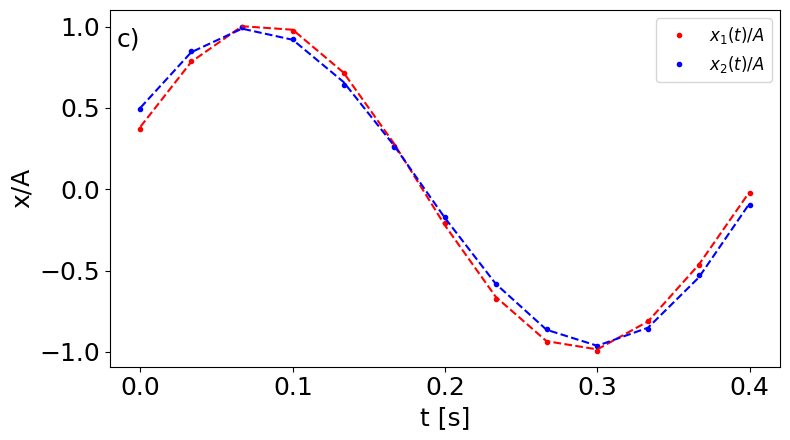


⏳ Procesando: Archivo 4

⚠️  Error en Archivo 4: No hay suficientes datos válidos para el ajuste.

⏳ Procesando: Archivo 5

--- Archivo 5 - ROJO ---
A1 = 25.175 ± 1.233
ω1 = 14.4058 ± 0.3632 rad/s
φ1 = -1.461 ± 0.081 rad
A2 = -2.609 ± 0.798
ω2 = 20.5908 ± 1.6305 rad/s
φ2 = 1.657 ± 0.666 rad
R²  = 0.99959

--- Archivo 5 - AZUL ---
A1 = -29.644 ± 23.343
ω1 = 15.1917 ± 1.0963 rad/s
φ1 = 1.412 ± 0.381 rad
A2 = 16.864 ± 22.341
ω2 = 16.8712 ± 1.5570 rad/s
φ2 = -4.556 ± 0.742 rad
R²  = 0.99937


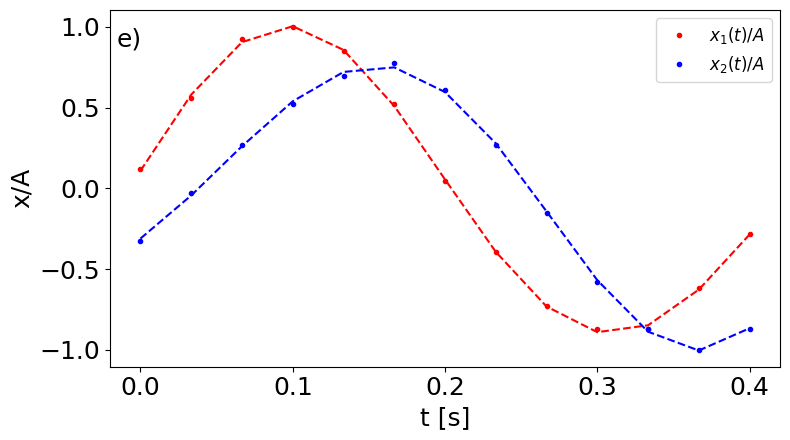


⏳ Procesando: Archivo 6

--- Archivo 6 - ROJO ---
A1 = 35.618 ± 1.270
ω1 = 6.4127 ± 0.1439 rad/s
φ1 = -1.038 ± 0.053 rad
A2 = -14.455 ± 1.443
ω2 = 10.7755 ± 0.1919 rad/s
φ2 = 0.623 ± 0.059 rad
R²  = 0.99986

--- Archivo 6 - AZUL ---
A1 = -29.914 ± 1.532
ω1 = 5.7426 ± 0.2360 rad/s
φ1 = 2.375 ± 0.092 rad
A2 = 20.733 ± 1.862
ω2 = 10.0768 ± 0.1600 rad/s
φ2 = 0.818 ± 0.051 rad
R²  = 0.99978


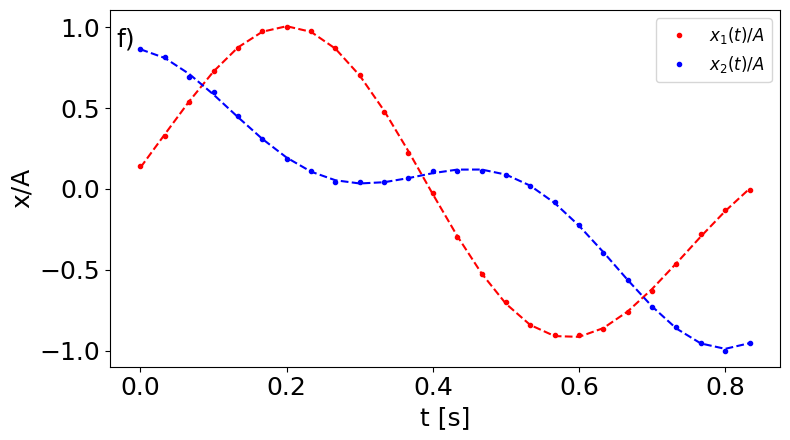


⏳ Procesando: Archivo 7

--- Archivo 7 - ROJO ---
A1 = 32.813 ± 1.379
ω1 = 14.1688 ± 0.3329 rad/s
φ1 = 4.821 ± 0.075 rad
A2 = 1.374 ± 1.367
ω2 = 49.7450 ± 8.3862 rad/s
φ2 = -0.737 ± 1.898 rad
R²  = 0.98864

--- Archivo 7 - AZUL ---
A1 = 24.619 ± 0.154
ω1 = 14.1290 ± 0.0754 rad/s
φ1 = -1.433 ± 0.019 rad
A2 = -13.577 ± 0.151
ω2 = 27.4948 ± 0.1278 rad/s
φ2 = 0.944 ± 0.033 rad
R²  = 0.99987


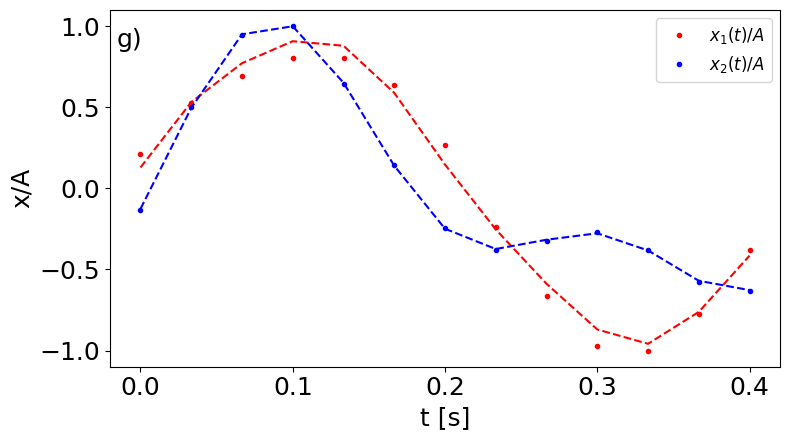

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# === Modelo: suma de dos cosenos ===
def modelo_suma_coseno(t, A1, w1, phi1, A2, w2, phi2):
    return A1 * np.cos(w1 * t + phi1) + A2 * np.cos(w2 * t + phi2)

# === Detectar cruces por cero positivos ===
def detectar_cruces_cero(x, t):
    cruces = []
    for i in range(1, len(x)):
        if x[i-1] < 0 and x[i] >= 0:
            t0 = t[i-1] + (0 - x[i-1]) * (t[i] - t[i-1]) / (x[i] - x[i-1])
            cruces.append((i, t0))
    return cruces

# === Procesamiento completo para un CSV ===
def procesar_csv(ruta_csv, periodo):
    df = pd.read_csv(ruta_csv)
    df['x_rojo_c'] = df['x_rojo'] - df['x_rojo'].mean()
    df['x_azul_c'] = df['x_azul'] - df['x_azul'].mean()
    t = df['tiempo_s'].values
    x1 = df['x_rojo_c'].values
    x2 = df['x_azul_c'].values

    cruces_cero = detectar_cruces_cero(x1, t)
    
    if len(cruces_cero) <= periodo + 1:
        raise IndexError(f"No hay suficientes cruces por cero para el periodo {periodo}. Se encontraron solo {len(cruces_cero)} cruces.")

    idx_ini = cruces_cero[periodo][0]
    idx_fin = cruces_cero[periodo+1][0]

    t_p = t[idx_ini:idx_fin] - t[idx_ini]
    x1_p = x1[idx_ini:idx_fin]
    x2_p = x2[idx_ini:idx_fin]

    return t_p, x1_p, x2_p

# === Ajustar y obtener errores (con limpieza de datos) ===
def ajustar_suma_coseno(t, x):
    mask = np.isfinite(t) & np.isfinite(x)
    t = t[mask]
    x = x[mask]

    if len(t) < 10:
        raise ValueError("No hay suficientes datos válidos para el ajuste.")

    T = t[-1] - t[0]
    w1_est = 2 * np.pi / T
    w2_est = 2 * w1_est
    A_est = np.max(np.abs(x))
    p0 = [A_est, w1_est, 0, A_est / 2, w2_est, 0]

    popt, pcov = curve_fit(modelo_suma_coseno, t, x, p0=p0, maxfev=10000)
    x_fit = modelo_suma_coseno(t, *popt)
    r2 = r2_score(x, x_fit)
    perr = np.sqrt(np.diag(pcov))

    return popt, perr, x_fit, r2

# === Imprimir resultados con errores ===
def imprimir_ajuste(nombre, popt, perr, r2):
    A1, w1, phi1, A2, w2, phi2 = popt
    dA1, dw1, dphi1, dA2, dw2, dphi2 = perr
    print(f"\n--- {nombre} ---")
    print(f"A1 = {A1:.3f} ± {dA1:.3f}")
    print(f"ω1 = {w1:.4f} ± {dw1:.4f} rad/s")
    print(f"φ1 = {phi1:.3f} ± {dphi1:.3f} rad")
    print(f"A2 = {A2:.3f} ± {dA2:.3f}")
    print(f"ω2 = {w2:.4f} ± {dw2:.4f} rad/s")
    print(f"φ2 = {phi2:.3f} ± {dphi2:.3f} rad")
    print(f"R²  = {r2:.5f}")

# === Gráfico ===
def graficar_ajuste(t, x1, x1_fit, x2, x2_fit, titulo, letra):
    size = 18
    fig, ax = plt.subplots(figsize=(8, 4.5))
    A1 = np.max(np.abs(x1))
    A2 = np.max(np.abs(x2))

    ax.plot(t, x1 / A1, 'r.', label='$x_1(t)/A$', markersize=6)
    ax.plot(t, x2 / A2, 'b.', label='$x_2(t)/A$', markersize=6)
    ax.plot(t, x1_fit / A1, 'r--')
    ax.plot(t, x2_fit / A2, 'b--')
    ax.set_xlabel('t [s]', fontsize=size)
    ax.set_ylabel('x/A', fontsize=size)
    ax.text(0.01, 0.95, f"{letra})", transform=ax.transAxes,
             fontsize=size, va='top', ha='left')
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=size)
    plt.tight_layout()
    plt.show()

# === Archivos ===
archivos = [
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv', 'periodo': 2, 'titulo': 'Archivo 1', 'letra': 'a'},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosModoRapido/trayectorias.csv', 'periodo': 10, 'titulo': 'Archivo 2', 'letra': 'b'},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesMetalicosModoLento/trayectorias.csv', 'periodo': 20, 'titulo': 'Archivo 3', 'letra': 'c'},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesMetalicosModoRapido/trayectorias.csv', 'periodo': 12, 'titulo': 'Archivo 4', 'letra': 'd'},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/2ResortesMetalicos1ResortePlastico/trayectorias.csv', 'periodo': 13, 'titulo': 'Archivo 5', 'letra': 'e'},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/CondicionesInicialesResortesPlasticosMasasIguales/trayectorias.csv', 'periodo': 14, 'titulo': 'Archivo 6', 'letra': 'f'},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasDistintasMetalicos/trayectorias.csv', 'periodo': 15, 'titulo': 'Archivo 7', 'letra': 'g'},
]

# === Ejecutar procesamiento ===
for archivo in archivos:
    try:
        print(f"\n⏳ Procesando: {archivo['titulo']}")
        t_p, x1_p, x2_p = procesar_csv(archivo['ruta'], archivo['periodo'])

        popt1, perr1, x1_fit, r2_1 = ajustar_suma_coseno(t_p, x1_p)
        popt2, perr2, x2_fit, r2_2 = ajustar_suma_coseno(t_p, x2_p)

        imprimir_ajuste(f"{archivo['titulo']} - ROJO", popt1, perr1, r2_1)
        imprimir_ajuste(f"{archivo['titulo']} - AZUL", popt2, perr2, r2_2)
        graficar_ajuste(t_p, x1_p, x1_fit, x2_p, x2_fit, archivo['titulo'], archivo['letra'])

    except Exception as e:
        print(f"\n⚠️  Error en {archivo['titulo']}: {e}")



=== Experimento 1 (Plásticos) - ω1 ===
α = 123.5666 ± 0.5228
β = 2900.6284 ± 26.2544
ω = 5.5000 rad/s
X = 3666.1935 ± 166.4971
Y = 3977.3973 ± 280.2787

=== Experimento 1 (Plásticos) - ω2 ===
α = 123.5666 ± 0.5228
β = 2900.6284 ± 26.2544
ω = 9.5000 rad/s
X = 3666.1935 ± 166.4971
Y = 3241.4109 ± 757.3142

=== Experimento 2 (Metálicos) - ω1 ===
α = 849.9545 ± 1.1237
β = 137656.8770 ± 370.4860
ω = 14.4000 rad/s
X = 171795.2084 ± 2417.6451
Y = 189429.1029 ± 13657.0422

=== Experimento 2 (Metálicos) - ω2 ===
α = 849.9545 ± 1.1237
β = 137656.8770 ± 370.4860
ω = 25.0000 rad/s
X = 171795.2084 ± 2417.6451
Y = 160036.3718 ± 40007.8302

=== Experimento 3 (Mixto) - ω1 ===
α = 497.7193 ± 0.7739
β = 60826.3443 ± 187.2673
ω = 14.2600 rad/s
X = 4419.1065 ± 1074.5054
Y = 8285.3835 ± 7634.1439

=== Experimento 3 (Mixto) - ω2 ===
α = 497.7193 ± 0.7739
β = 60826.3443 ± 187.2673
ω = 16.7800 rad/s
X = 4419.1065 ± 1074.5054
Y = 4279.4517 ± 10455.8972

=== Experimento 4 (Masas distintas) - ω1 ===
α = 950.950

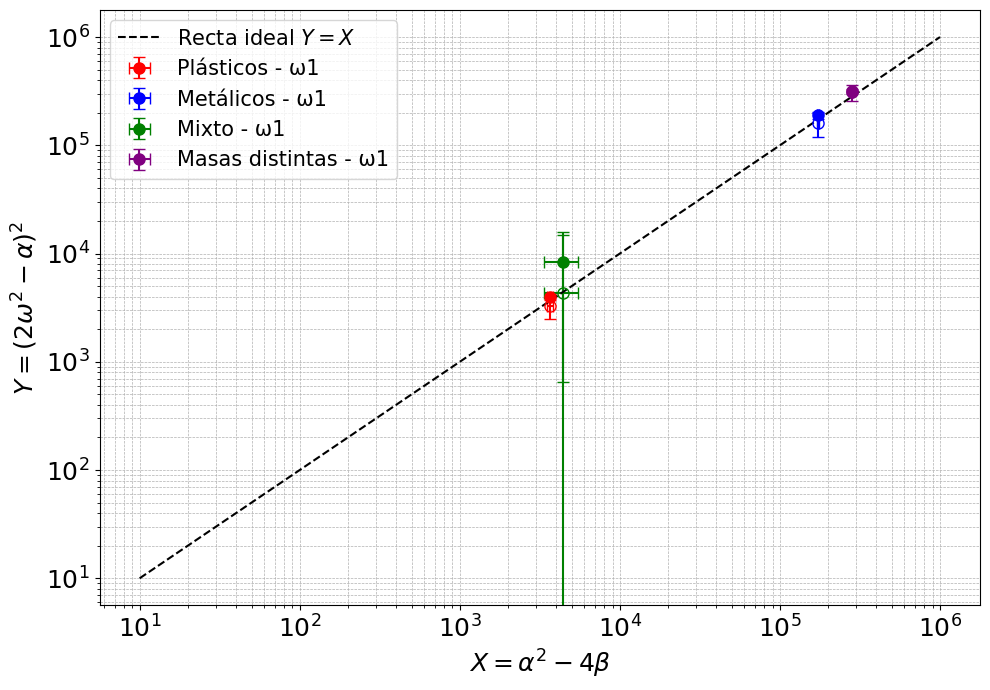

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# === Incertidumbres conocidas ===
dk1 = 0.05
dk2 = 0.05
dk3 = 0.1
dm1 = 0.0005
dm2 = 0.0005

# === Datos: [k1, k2, k3, m1, m2, omega1, omega2]
datos = np.array([
    [9.34, 9.05, 9.5, 0.2993, 0.2986, 5.5, 9.5],
    [67.9, 61.9, 62.4, 0.2993, 0.2986, 14.4, 25.0],
    [67.9, 9.5, 61.9, 0.2993, 0.2986, 14.26, 16.78],
    [67.9, 61.9, 62.4, 0.3993, 0.1986, 13.96, 27.45],
])

colores = ['red', 'blue', 'green', 'purple']
etiquetas = ['Plásticos', 'Metálicos', 'Mixto', 'Masas distintas']
Fsize = 18

# === Propagación de incertidumbre de alpha y beta
def incertidumbre_alpha_beta(k1, k2, k3, m1, m2):
    alpha = (k1 + k2) / m1 + (k2 + k3) / m2
    beta = (k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2)

    d_alpha = np.sqrt(
        ((1 / m1) * dk1)**2 +
        ((1 / m1 + 1 / m2) * dk2)**2 +
        ((1 / m2) * dk3)**2 +
        (((k1 + k2) / m1**2) * dm1)**2 +
        (((k2 + k3) / m2**2) * dm2)**2
    )

    d_beta = np.sqrt(
        ((k2 + k3) / (m1 * m2) * dk1)**2 +
        ((k1 + k3) / (m1 * m2) * dk2)**2 +
        ((k1 + k2) / (m1 * m2) * dk3)**2 +
        ((k1 * k2 + k1 * k3 + k2 * k3) / (m1**2 * m2) * dm1)**2 +
        ((k1 * k2 + k1 * k3 + k2 * k3) / (m1 * m2**2) * dm2)**2
    )
    return alpha, beta, d_alpha, d_beta

# === Graficar ===
plt.figure(figsize=(10, 7))

for i, (k1, k2, k3, m1, m2, omega1, omega2) in enumerate(datos):
    color = colores[i]
    etiqueta = etiquetas[i]

    alpha, beta, d_alpha, d_beta = incertidumbre_alpha_beta(k1, k2, k3, m1, m2)

    for j, omega in enumerate([omega1, omega2], start=1):
        modo = f"ω{j}"
        marcador = 'o'
        borde = {} if j == 1 else {'markerfacecolor': 'none'}

        omega_sq = omega**2
        X = alpha**2 - 4 * beta
        Y = (2 * omega_sq - alpha)**2

        # Errores (ω asumido con 1% de error relativo)
        dX = np.sqrt((2 * alpha * d_alpha)**2 + (4 * d_beta)**2)
        dY = np.sqrt(
            (4 * (2 * omega) * (2 * omega - alpha) * (0.01 * omega))**2 +
            (2 * (2 * omega_sq - alpha) * d_alpha)**2
        )

        print(f"\n=== Experimento {i+1} ({etiqueta}) - {modo} ===")
        print(f"α = {alpha:.4f} ± {d_alpha:.4f}")
        print(f"β = {beta:.4f} ± {d_beta:.4f}")
        print(f"ω = {omega:.4f} rad/s")
        print(f"X = {X:.4f} ± {dX:.4f}")
        print(f"Y = {Y:.4f} ± {dY:.4f}")

        plt.errorbar(
            X, Y, xerr=dX, yerr=dY, fmt=marcador, color=color,
            label=f"{etiqueta} - {modo}" if j == 1 else None,
            markersize=8, elinewidth=1.5, capsize=4, **borde
        )

# === Recta ideal Y = X ===
X_line = np.logspace(1, 6, 500)
plt.plot(X_line, X_line, '--', color='black', label='Recta ideal $Y = X$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$X = \alpha^2 - 4\beta$', fontsize=Fsize)
plt.ylabel(r'$Y = (2\omega^2 - \alpha)^2$', fontsize=Fsize)
plt.legend(fontsize=Fsize - 3)
plt.xticks(fontsize=Fsize)
plt.yticks(fontsize=Fsize)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


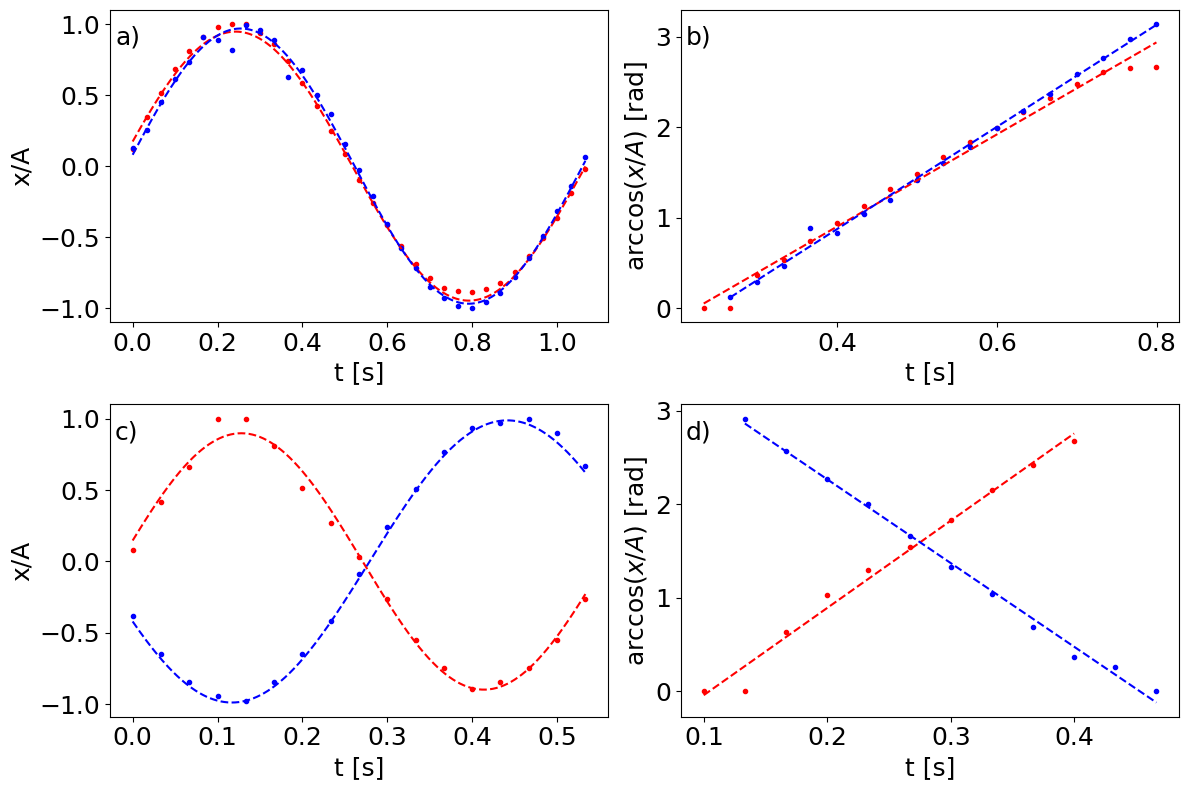


=== Resultados de regresión para: Archivo 1 ===
θ₁(t): ω₁ = 5.1017 ± 0.1500 rad/s
         ϕ₁ = -1.1397 ± 0.0817 rad
θ₂(t): ω₂ = 5.6572 ± 0.0884 rad/s
         ϕ₂ = -1.3892 ± 0.0493 rad

=== Resultados de regresión para: Archivo 2 ===
θ₁(t): ω₁ = 9.3217 ± 0.3950 rad/s
         ϕ₁ = -0.9713 ± 0.1057 rad
θ₂(t): ω₂ = -8.9449 ± 0.2068 rad/s
         ϕ₂ = 4.0547 ± 0.0657 rad


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# === Funciones auxiliares ===
def modelo_coseno(t, A, w, phi):
    return A * np.cos(w * t + phi)

def detectar_cruces_cero(x, t):
    cruces = []
    for i in range(1, len(x)):
        if x[i-1] < 0 and x[i] >= 0:
            t0 = t[i-1] + (0 - x[i-1]) * (t[i] - t[i-1]) / (x[i] - x[i-1])
            cruces.append((i, t0))
    return cruces

def datos_arccos(t, x_n):
    idx_min = np.argmin(x_n)
    idx_max = np.argmax(x_n)
    if idx_min > idx_max:
        idx_min, idx_max = idx_max, idx_min
    t_seg = t[idx_min:idx_max+1]
    y_seg = np.arccos(x_n[idx_min:idx_max+1])
    return t_seg, y_seg

def ajuste_lineal(t, y):
    result = linregress(t, y)
    return result.slope, result.intercept, result.rvalue**2, result.stderr, result.intercept_stderr

def procesar_datos(ruta_csv, numero_periodo):
    df = pd.read_csv(ruta_csv)
    df['x_rojo_c'] = df['x_rojo'] - df['x_rojo'].mean()
    df['x_azul_c'] = df['x_azul'] - df['x_azul'].mean()
    t = df['tiempo_s'].values
    x1 = df['x_rojo_c'].values
    x2 = df['x_azul_c'].values

    cruces_cero = detectar_cruces_cero(x1, t)
    idx_ini = cruces_cero[numero_periodo][0]
    idx_fin = cruces_cero[numero_periodo+1][0]
    t_p = t[idx_ini:idx_fin] - t[idx_ini]
    x1_p = x1[idx_ini:idx_fin]
    x2_p = x2[idx_ini:idx_fin]

    T_est = t_p[-1] - t_p[0]
    w_est = 2 * np.pi / T_est
    p0 = [np.max(np.abs(x1_p)), w_est, 0]
    popt1, _ = curve_fit(modelo_coseno, t_p, x1_p, p0=p0)
    popt2, _ = curve_fit(modelo_coseno, t_p, x2_p, p0=p0)

    A1 = np.max(np.abs(x1_p))
    A2 = np.max(np.abs(x2_p))
    x1_n = x1_p / A1
    x2_n = x2_p / A2

    t1_arccos, y1_arccos = datos_arccos(t_p, x1_n)
    t2_arccos, y2_arccos = datos_arccos(t_p, x2_n)
    slope1, intercept1, _, stderr1, intercept_err1 = ajuste_lineal(t1_arccos, y1_arccos)
    slope2, intercept2, _, stderr2, intercept_err2 = ajuste_lineal(t2_arccos, y2_arccos)

    return {
        't_p': t_p, 'x1_n': x1_n, 'x2_n': x2_n,
        'popt1': popt1, 'popt2': popt2, 'A1': A1, 'A2': A2,
        't1_arccos': t1_arccos, 'y1_arccos': y1_arccos,
        't2_arccos': t2_arccos, 'y2_arccos': y2_arccos,
        'slope1': slope1, 'intercept1': intercept1, 'stderr1': stderr1, 'intercept_err1': intercept_err1,
        'slope2': slope2, 'intercept2': intercept2, 'stderr2': stderr2, 'intercept_err2': intercept_err2
    }

def graficar_resultados(data1, data2):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    sizeLetras = 18

    for i, data in enumerate([data1, data2]):
        row = i

        # a, c: Señales normalizadas + ajuste
        t_fit = np.linspace(data['t_p'].min(), data['t_p'].max(), 500)
        axs[row, 0].plot(data['t_p'], data['x1_n'], 'r.')
        axs[row, 0].plot(data['t_p'], data['x2_n'], 'b.')
        axs[row, 0].plot(t_fit, modelo_coseno(t_fit, *data['popt1']) / data['A1'], 'r--')
        axs[row, 0].plot(t_fit, modelo_coseno(t_fit, *data['popt2']) / data['A2'], 'b--')
        axs[row, 0].set_xlabel('t [s]', fontsize=sizeLetras)
        axs[row, 0].set_ylabel('x/A', fontsize=sizeLetras)
        axs[row, 0].tick_params(labelsize=sizeLetras)
        axs[row, 0].text(0.01, 0.95, f"{chr(97 + row*2)})", transform=axs[row, 0].transAxes,
                         fontsize=sizeLetras, va='top')

        # b, d: arccos + regresión
        axs[row, 1].plot(data['t1_arccos'], data['y1_arccos'], 'r.')
        axs[row, 1].plot(data['t2_arccos'], data['y2_arccos'], 'b.')
        axs[row, 1].plot(data['t1_arccos'], data['slope1'] * data['t1_arccos'] + data['intercept1'], 'r--')
        axs[row, 1].plot(data['t2_arccos'], data['slope2'] * data['t2_arccos'] + data['intercept2'], 'b--')
        axs[row, 1].set_xlabel('t [s]', fontsize=sizeLetras)
        axs[row, 1].set_ylabel(r'$\arccos(x/A)$ [rad]', fontsize=sizeLetras)
        axs[row, 1].tick_params(labelsize=sizeLetras)
        axs[row, 1].text(0.01, 0.95, f"{chr(98 + row*2)})", transform=axs[row, 1].transAxes,
                         fontsize=sizeLetras, va='top')

    plt.tight_layout()
    plt.show()

# === Rutas y parámetros
ruta1 = '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv'
ruta2 = '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosModoRapido/trayectorias.csv'
periodo1 = 6
periodo2 = 20

datos1 = procesar_datos(ruta1, periodo1)
datos2 = procesar_datos(ruta2, periodo2)
graficar_resultados(datos1, datos2)

# === Mostrar resultados de regresión
def imprimir_regresiones(nombre, datos):
    print(f"\n=== Resultados de regresión para: {nombre} ===")
    print(f"θ₁(t): ω₁ = {datos['slope1']:.4f} ± {datos['stderr1']:.4f} rad/s")
    print(f"         ϕ₁ = {datos['intercept1']:.4f} ± {datos['intercept_err1']:.4f} rad")
    print(f"θ₂(t): ω₂ = {datos['slope2']:.4f} ± {datos['stderr2']:.4f} rad/s")
    print(f"         ϕ₂ = {datos['intercept2']:.4f} ± {datos['intercept_err2']:.4f} rad")

imprimir_regresiones("Archivo 1", datos1)
imprimir_regresiones("Archivo 2", datos2)


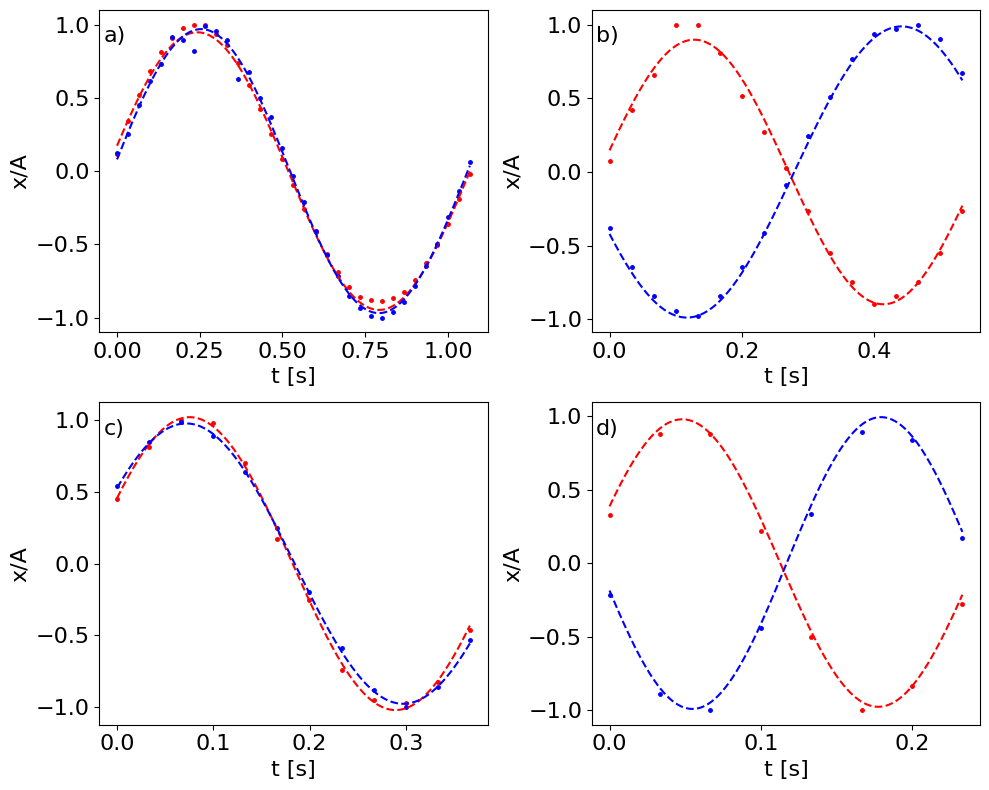

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Funciones auxiliares ===
def modelo_coseno(t, A, w, phi):
    return A * np.cos(w * t + phi)

def detectar_cruces_cero(x, t):
    cruces = []
    for i in range(1, len(x)):
        if x[i-1] < 0 and x[i] >= 0:
            t0 = t[i-1] + (0 - x[i-1]) * (t[i] - t[i-1]) / (x[i] - x[i-1])
            cruces.append((i, t0))
    return cruces

def procesar_datos(ruta_csv, numero_periodo):
    df = pd.read_csv(ruta_csv)
    df['x_rojo_c'] = df['x_rojo'] - df['x_rojo'].mean()
    df['x_azul_c'] = df['x_azul'] - df['x_azul'].mean()
    t = df['tiempo_s'].values
    x1 = df['x_rojo_c'].values
    x2 = df['x_azul_c'].values

    cruces_cero = detectar_cruces_cero(x1, t)
    idx_ini = cruces_cero[numero_periodo][0]
    idx_fin = cruces_cero[numero_periodo+1][0]
    t_p = t[idx_ini:idx_fin] - t[idx_ini]
    x1_p = x1[idx_ini:idx_fin]
    x2_p = x2[idx_ini:idx_fin]

    T_est = t_p[-1] - t_p[0]
    w_est = 2 * np.pi / T_est
    p0 = [np.max(np.abs(x1_p)), w_est, 0]
    popt1, _ = curve_fit(modelo_coseno, t_p, x1_p, p0=p0)
    popt2, _ = curve_fit(modelo_coseno, t_p, x2_p, p0=p0)

    A1 = np.max(np.abs(x1_p))
    A2 = np.max(np.abs(x2_p))
    x1_n = x1_p / A1
    x2_n = x2_p / A2

    return {
        't_p': t_p, 'x1_n': x1_n, 'x2_n': x2_n,
        'popt1': popt1, 'popt2': popt2, 'A1': A1, 'A2': A2
    }

def graficar_resultados(lista_datos):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    sizeLetras = 16

    for i, data in enumerate(lista_datos):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        t_fit = np.linspace(data['t_p'].min(), data['t_p'].max(), 500)
        ax.plot(data['t_p'], data['x1_n'], 'r.', label='$x_1(t)/A$', markersize=5)
        ax.plot(data['t_p'], data['x2_n'], 'b.', label='$x_2(t)/A$', markersize=5)
        ax.plot(t_fit, modelo_coseno(t_fit, *data['popt1']) / data['A1'], 'r--')
        ax.plot(t_fit, modelo_coseno(t_fit, *data['popt2']) / data['A2'], 'b--')

        ax.set_xlabel('t [s]', fontsize=sizeLetras)
        ax.set_ylabel('x/A', fontsize=sizeLetras)
        ax.tick_params(labelsize=sizeLetras)
        ax.text(0.01, 0.95, f"{chr(97 + i)})", transform=ax.transAxes,
                fontsize=sizeLetras, va='top')

    plt.tight_layout()
    plt.show()

# === Rutas y parámetros ===
archivos = [
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv', 'periodo': 6},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosModoRapido/trayectorias.csv', 'periodo': 20},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesMetalicosModoLento/trayectorias.csv', 'periodo': 5},
    {'ruta': '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesMetalicosModoRapido/trayectorias.csv', 'periodo': 8},
]

# === Procesar y graficar ===
datos_lista = [procesar_datos(a['ruta'], a['periodo']) for a in archivos]
graficar_resultados(datos_lista)
